## Introduction

The Drug Review dataset, sourced from UCI, contains patient reviews on various prescription drugs, and consists of 21,5063 instances and 6 features.  

The dataset provides insights regarding effectiveness, side effects and overall satisfaction in medications for specific health conditions.

It is a rich resource for NLP Tasks, such as sentiment analysis and text classifcation, due to a combination of textual and numerical values.

By using NLP models to analyse the reviews, potential drug issues can be identified and patient outcomes can be improved.




# Preprocessing

In [2]:
!pip install --upgrade transformers
!pip install datasets

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score

import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
import re

from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import torch


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
stop_words = stopwords.words('english')
vectorizer = TfidfVectorizer(stop_words=stop_words)
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
file_path = '/content/drive/MyDrive/Uni/Advanced Artificial Intelligence/drugsComTest_converted.csv'
drugs_df = pd.read_csv(file_path)
drugs_df.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10.0,"February 28, 2012",22
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8.0,"May 17, 2009",17
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9.0,"September 29, 2017",3
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9.0,"March 5, 2017",35
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9.0,"October 22, 2015",4


In [7]:
drugs_df.info()
drugs_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53766 entries, 0 to 53765
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   53766 non-null  int64  
 1   drugName     53766 non-null  object 
 2   condition    53471 non-null  object 
 3   review       53766 non-null  object 
 4   rating       53766 non-null  float64
 5   date         53766 non-null  object 
 6   usefulCount  53766 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 2.9+ MB


,Unnamed: 0,rating,usefulCount
count,53766.000000,53766.000000,53766.000000
mean,116386.701187,6.976900,27.989752
std,67017.739881,3.285207,36.172833
min,0.000000,1.000000,0.000000
25%,58272.500000,4.000000,6.000000
50%,116248.500000,8.000000,16.000000
75%,174586.750000,10.000000,36.000000
max,232284.000000,10.000000,949.000000


## Representation Learning

To make sure this data set could be processed effectively, several techniques were implemented to convert the raw data into meaningful representations suitable for models.

NLTK was used to perform text preprocessing, which consisted of StopWord removal and Lemmatisation.

The re library was used for additional preprocessing so the sole focus was word content and encoded characters were normalised/replaced.

The processed text was then transformed into numerical vectors using TF-IDF, where each term is weighted based on its frequency in a dataset and its rarity across an entire dataset. This emphasises terms that are important in some reviews but aren't common across all reviews.



In [ ]:
drugs_df['review'].head()

lemmatizer = WordNetLemmatizer()

import html

import string
def preprocess_text(text):
    if text is None:
        return ''
    if isinstance(text, str):
        text = html.unescape(text)
        text = text.lower()
        text = re.sub(r'039', "'", text)
        text = text.translate(str.maketrans('', '', string.punctuation))
        words = text.split()
        text = ' '.join(lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words)
        text = text.strip()
        return text if isinstance(text, str) else ''


drugs_df['cleaned_review'] = drugs_df['review'].apply(preprocess_text)

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

drugs_df['cleaned_review'] = drugs_df['cleaned_review'].apply(
    lambda x: ' '.join(word for word in x.split() if word.lower() not in stop_words) if isinstance(x, str) else '')


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=10000)
tfidf_vectors = vectorizer.fit_transform(drugs_df['cleaned_review'])

print("TF-IDF Vectorization Complete")

print("Shape of TF-IDF Matrix:", tfidf_vectors.shape)

print(vectorizer.get_feature_names_out()[:10])

print(drugs_df['cleaned_review'].iloc[0])

print(tfidf_vectors[0].toarray())




In [ ]:
review_vector = tfidf_vectors[0].toarray()[0]
terms = vectorizer.get_feature_names_out()
term_weights = [(terms[i], review_vector[i]) for i in range(len(review_vector)) if review_vector[i] > 0]
print(term_weights)

In [ ]:
html_rows = drugs_df[drugs_df['cleaned_review'].str.contains('&', na=False)]
print(html_rows.head())

drugs_df['cleaned_review'] = drugs_df['review'].apply(preprocess_text)
print(drugs_df['cleaned_review'].str.contains('amp').sum())  # Should return 0


## Algorithms

K-Nearest Neighbour is an instance-based algorithm used for regression tasks.
It classifies text by comparing it to the most similar examples in the training data using a distance metric (cosine, euclidean).

The text reviews are transformed into numerical vectors using TF-IDF and the cosine similarity metric is used to determine the "closeness" between reviews, and the target value (effectiveness rating) is predicted as the weighted average of the nearest neighbour's ratings.

This algorithm is simple, interpretable and performs well with smaller datasets, but does not inherently identify complex patterns in text data, and is computationally expensive for larger datasets due to distance calculations.

In [12]:
X = drugs_df['cleaned_review']
y = drugs_df['rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer(max_features=30000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

knn = KNeighborsRegressor(n_neighbors=35, metric='cosine')
knn.fit(X_train_tfidf, y_train)

y_pred = knn.predict(X_test_tfidf)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 7.797587456779253
R-squared: 0.275371840657909


The DistilBERT transformer is a more efficient version of the BERT (Bidirectional Encoder Representation from Transformers) model. It uses a process called knowledge distillation, in which a large pre-trained model transfers its knowledge to a smaller model, and the former's outputs are used to train the latter to mimic the larger dataset.

It uses the self-attention mechanism to comprehend relationships between all words in a sentence simultaneously, regardless of position. It processes the text in both directions, allowing it to understand the full context of a word based on its surroundings.

DistilBERT is a lightweight algorithm with reduced computational cost without significant loss in accuracy, but does still requires GPUs for efficient training.

In [13]:
import os

os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

In [14]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import mean_squared_error, r2_score
import torch
from tqdm import tqdm
import numpy as np

model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=128)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=1).to("cuda")

train_dataset = Dataset.from_dict({"review": X_train.tolist(), "labels": y_train.tolist()})
test_dataset = Dataset.from_dict({"review": X_test.tolist(), "labels": y_test.tolist()})

def preprocess_function(examples):
    return tokenizer(examples["review"], padding="max_length", truncation=True)

train_dataset = train_dataset.map(preprocess_function, batched=True)
test_dataset = test_dataset.map(preprocess_function, batched=True)

training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=20,
    num_train_epochs=2,
    learning_rate=2e-5,
    weight_decay=0.01,
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

trainer.train()

torch.cuda.empty_cache()

batch_size = 15
y_pred_transformer = []

for i in tqdm(range(0, len(drugs_df['review']), batch_size)):
    batch_reviews = drugs_df['review'][i:i + batch_size].tolist()
    tokenized_batch = tokenizer(batch_reviews, padding="max_length", truncation=True, return_tensors="pt").to(model.device)

    with torch.no_grad():
        prediction_outputs = model(**tokenized_batch)

    predictions = torch.sigmoid(prediction_outputs.logits).cpu().detach().numpy()
    y_pred_transformer.extend(predictions.flatten())

mse_transformer = mean_squared_error(y_test, y_pred_transformer[:len(y_test)])
r2_transformer = r2_score(y_test, y_pred_transformer[:len(y_test)])

print(f"Transformer: MSE = {mse_transformer:.4f}, R-squared = {r2_transformer:.4f}")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/43012 [00:00<?, ? examples/s]

Map:   0%|          | 0/10754 [00:00<?, ? examples/s]

Step,Training Loss
500,12.381200
1000,7.640500
1500,6.522200
2000,6.566700
2500,6.311300
3000,5.618000
3500,5.746500
4000,5.406900
4500,5.415600
5000,5.211300


100%|██████████| 3585/3585 [03:26<00:00, 17.38it/s]


Transformer: MSE = 46.6796, R-squared = -3.3379


SVR is a classical machine learning algorithm that models the relationship between input features (TF-IDF vectors) and the target variable. SVR is used to predict ratings as a continuous value.

It is effective with smaller datasets and TF-IDF features, and can capture non-linear relationships, but can be sensitive to feature scaling and outliers and doesn't leverage a contextual understanding of the text like some other algorithms (e.g. BERT).

In [18]:
X = drugs_df['review']
y = drugs_df['rating']

from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_extraction.text import TfidfVectorizer

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer(max_features=10000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print("SVR training...")

svr = SVR(kernel='rbf', C=1.0, epsilon=0.1)
svr.fit(X_train_tfidf, y_train)
print("SVR training completed.")

y_pred_svr = svr.predict(X_test_tfidf)

mse_svr = mean_squared_error(y_test, y_pred_svr)
r2_svr = r2_score(y_test, y_pred_svr)

print(f"SVR: MSE = {mse_svr:.4f}, R-squared = {r2_svr:.4f}")

import time
svr = SVR(kernel='rbf', C=1.0, epsilon=0.1)

start_time = time.time()
svr.fit(X_train_tfidf, y_train)
end_time = time.time()

print(f"SVR training took {end_time - start_time:.2f} seconds")

SVR training...
SVR training completed.
SVR: MSE = 5.6746, R-squared = 0.4727
SVR training took 2508.72 seconds


### Evaluation

The performance of kNN, BERT Transformer and SVR was evaluated on the task of predicting drug effectiveness based on textual reviews. The evaluation metrics used were Mean Squared Error and R-Squared

For kNN, The MSE of 7.80 reflects reasonable prediction accuracy, but kNN struggles to capture deeper patterns in the data due to its reliance on local similarity.

For BERT Transformer, the MSE of 46.68 suggest the model performed poorly on this regression task.

SVR outperformed both kNN and BERT, achieving the lowest MSE (5.67) and the highest R² (0.473).

This demonstrates SVR's ability to handle high-dimensional TF-IDF features effectively while capturing meaningful relationships in the data.



In [19]:
from IPython.display import display
import pandas as pd

results = {
    "Model": ["kNN", "BERT", "SVR"],
    "MSE": [mse, mse_transformer, mse_svr],
    "R-Squared": [r2, r2_transformer, r2_svr]
}

results_df = pd.DataFrame(results)
print(results_df)

  Model        MSE  R-Squared
0   kNN   7.797587   0.275372
1  BERT  46.679647  -3.337930
2   SVR   5.674615   0.472659


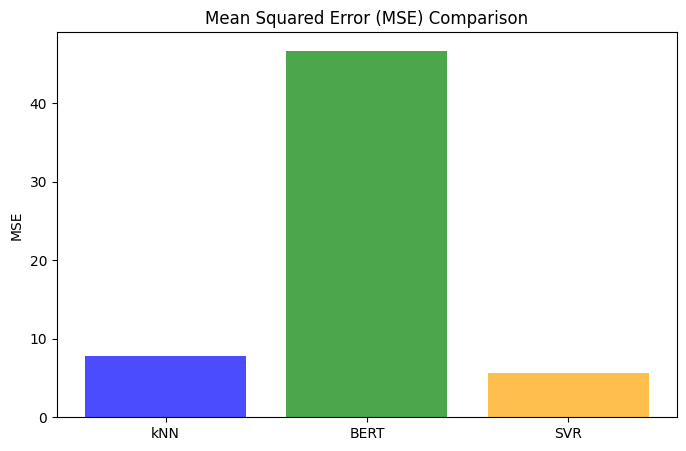

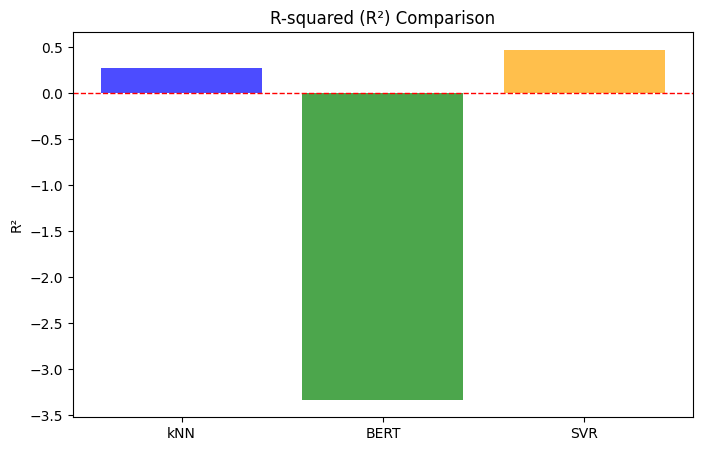

In [20]:
import matplotlib.pyplot as plt

models = ["kNN", "BERT", "SVR"]
mse_values = [7.79, 46.67, 5.67]
r2_values = [0.27, -3.33, 0.47]

plt.figure(figsize=(8, 5))
plt.bar(models, mse_values, color=['blue', 'green', 'orange'], alpha=0.7)
plt.title("Mean Squared Error (MSE) Comparison")
plt.ylabel("MSE")
plt.show()

plt.figure(figsize=(8, 5))
plt.bar(models, r2_values, color=['blue', 'green', 'orange'], alpha=0.7)
plt.title("R-squared (R²) Comparison")
plt.ylabel("R²")
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.show()